In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import make_scorer, f1_score, confusion_matrix, precision_score, recall_score, accuracy_score
from nltk.corpus import stopwords

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Embedding, Dense
from keras.utils import pad_sequences
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

import pickle

In [12]:
df = pd.read_csv("dataset/train.csv")
df.head(5)

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo


In [13]:
df['review_es'].isnull().sum()
df['sentimiento_es_positivo'] = np.where(df.sentimiento == 'positivo', 1, 0)
df['review_es'] = df['review_es'].str.lower()

caracteres_especiales = {'á':'a', 'é':'e', 'í':'i', 'ó':'o', 'ú':'u', 'ñ':'n'}
for original, nuevo in caracteres_especiales.items():
    df['review_es'] = df['review_es'].str.replace(original, nuevo, regex=True)
    
df['review_es'] = df['review_es'].str.replace('[^a-zA-Z]', ' ', regex=True)
df['review_es'] = df['review_es'].str.replace('  ', ' ', regex=True)

from nltk.corpus import stopwords
palabras = '|'.join(stopwords.words('spanish'))
df['review_es'] = df['review_es'].str.replace(fr'\b({palabras})\b', '',regex=True)

In [14]:
X = df.review_es
y = df.sentimiento_es_positivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocabulario = len(tokenizer.word_index) + 1

In [16]:
max_words = 50
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_words)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_words)

In [17]:
lstm_nn = Sequential()

lstm_nn.add(Embedding(vocabulario, 32, input_length=max_words,trainable=True))
lstm_nn.add(LSTM(units = 60, activation="relu", kernel_regularizer="l2", return_sequences = False,recurrent_dropout=0.2))
#lstm_nn.add(LSTM(40, activation="softmax", kernel_regularizer="l2"))
lstm_nn.add(Dense(20, activation="relu", kernel_regularizer = "l2"))
lstm_nn.add(Dense(1, activation='sigmoid'))

In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 32)            4889824   
                                                                 
 lstm (LSTM)                 (None, 60)                22320     
                                                                 
 dense (Dense)               (None, 20)                1220      
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 4,913,385
Trainable params: 4,913,385
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
lstm_nn_history = lstm_nn.fit(X_train_padded, y_train, epochs=4, callbacks = EarlyStopping(monitor='loss', patience=1))

Epoch 1/4
1250/1250 [==============================] - 71s 55ms/step - loss: 288.4833 - accuracy: 0.6052
Epoch 2/4
1250/1250 [==============================] - 69s 56ms/step - loss: 0.5838 - accuracy: 0.7923
Epoch 3/4
1250/1250 [==============================] - 70s 56ms/step - loss: 214.7078 - accuracy: 0.8857


In [20]:
y_pred = np.where(lstm_nn.predict(X_test_padded) >= 0.5, 1, 0)

313/313 [==============================] - 2s 6ms/step


Text(0.5, 1.0, 'Confusion matrix de validación')

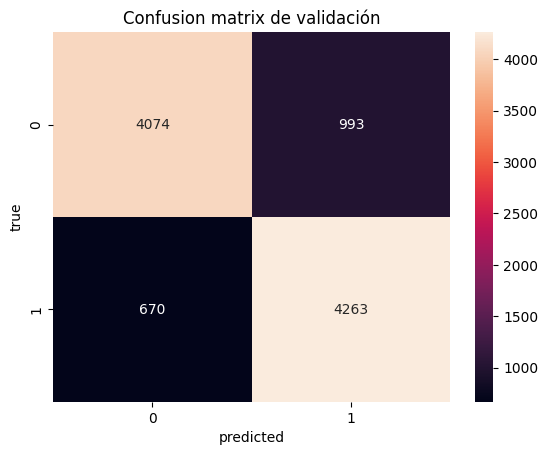

In [21]:
confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True, fmt='.0f')
plt.ylabel('true')
plt.xlabel('predicted')
plt.title("Confusion matrix de validación")

In [22]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))

Accuracy: 0.8337
Precision: 0.8110730593607306
Recall: 0.864180012162984
F1-score: 0.8367847678869369


In [23]:
df_test = pd.read_csv("dataset/test.csv")
assert(len(df_test)==8599)

X = df_test.review_es
X_sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_sequences, maxlen=max_words)
    
prediccion = np.where(lstm_nn.predict(X_padded) >= 0.5, 'positivo', 'negativo').reshape(-1)
assert(len(prediccion)==8599)

submit = pd.DataFrame(
    {"sentimiento": prediccion},
    index=df_test["ID"],
)
assert(len(submit)==8599)

submit.to_csv("dataset/submit.csv")

269/269 [==============================] - 1s 5ms/step


In [27]:
with open('modelos/RedNeuronal.pickle', 'wb') as file:
    pickle.dump(lstm_nn, file)